# Adding custom feature to TE
 
TE comes with several built-in features, such as `LogFp8TensorStats`, which can log statistics for each tensor involved in matrix multiplication (GEMM) operations.
In this tutorial, we'll demonstrate how to extend TE by adding a custom feature that logs the percentage of elements in a tensor whose absolute values exceed a configurable threshold `t`, as specified in the config file.

Custom features can be used for example for:

1. Logging custom statistics.
2. Dumping intermediate tensors.
3. Experiments with modifying intermediate tensors.

How to add custom feature:

1. Add Python with feature class definition which inherits from `transformer_engine.debug.features.api.TEConfigAPIMapper`.
2. Wrap the class with `@Registry.register_feature(namespace="transformer_engine")`.
3. Implement some of API calls to nvidia-dl-framework-inspect described [here](../3_api_te_calls.rst).

Let's define a new file at `.../custom_feature_dir/percentage_greater_than_threshold.py` containing the following code:



In [9]:
from IPython.display import Code
Code(filename='./custom_feature_dir/percentage_greater_than_threshold.py', language='python')

# Copyright (c) 2022-2025, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
#
# See LICENSE for license information.

"""PercentageGreaterThanThreshold Feature support for nvidia-dlframework-inspect"""

from typing import Dict, Optional

import torch

from nvdlfw_inspect.registry import Registry, api_method
from nvdlfw_inspect.logging import MetricLogger
import nvdlfw_inspect.api as debug_api

from transformer_engine.debug.features.api import TEConfigAPIMapper
from transformer_engine.pytorch.tensor import QuantizedTensor, Quantizer


# Class should inherit from TEConfigAPIMapper and be registered to the transformer_engine namespace.
@Registry.register_feature(namespace="transformer_engine")
class PercentageGreaterThanThreshold(TEConfigAPIMapper):

    @api_method
    def inspect_tensor(
        self,
        config: Dict,
        layer_name: str,
        tensor_name: str,
        iteration: int,
        tp_group: torch.distributed.ProcessGroup,
        tensor: torch.Tensor,
        rowwise_quantized_tensor: Optional[torch.Tensor | QuantizedTensor] = None,
        columnwise_quantized_tensor: Optional[torch.Tensor | QuantizedTensor] = None,
        quantizer: Optional[Quantizer] = None,
    ):
        # API call inspect_tensor is used to gather the data about the tensor.
        # All API calls are documented in the `Precision debug tools / API / Calls to Nvidia-DL-Framework-Inspect`
        # section of the documentation.

        threshold = config["threshold"]
        
        # Get the reduction group from the debug tool
        # one can set it using debug_api.set_tensor_reduction_group(group)
        reduction_group = debug_api.get_tensor_reduction_group()
        
        # Compute percentage on local tensor
        count = (tensor > threshold).sum().float()
        total = torch.tensor(tensor.numel(), dtype=torch.float32, device=tensor.device)
        
        # Perform reduction across the group if needed
        if reduction_group is not None:
            torch.distributed.all_reduce(count, group=reduction_group)
            torch.distributed.all_reduce(total, group=reduction_group)
        
        percentage = count / total

        # MetricLogger is a class from nvidia-dlframework-inspect.
        # By using it we can also use functionalities provided by nvidia-dlframework-inspect,
        # like logging to TensorBoard, etc.
        MetricLogger.log_scalar(
            f"{layer_name}_{tensor_name}_percentage_greater_than_threshold", percentage, iteration
        )

    @api_method
    def inspect_tensor_enabled(
        self, config: Dict, layer_name: str, tensor_name: str, iteration: int
    ):
        # This call is used by TE to determine if the unfused debug layer - which is slower - needs to be run.
        # It returns a tuple (bool, int), where the int indicates the next iteration when the feature will be enabled
        # and bool indicates if the feature should be enabled at the current iteration.
        
        
        run_current = iteration % config["freq"] == 0
        # run in next multiple of freq
        next_iter = iteration + (config["freq"] - iteration % config["freq"])
        return run_current, next_iter

Let's prepare simple config file and training script.
```yaml
# custom_feature_example_config.yaml
stats:
  enabled: True
  layers:
    layer_name_regex_pattern: .*
  transformer_engine:
    PercentageGreaterThanThreshold:
      enabled: True
      tensors: [activation]
      threshold: 0.1
      freq: 5
    LogTensorStats:
      enabled: True
      tensors: [activation]
      stats: [min]
      freq: 5
```

To use this feature one needs to add `.../custom_feature_dir` to `debug_api.initialize(feature_dirs=...`.

In [ ]:
import time
import torch
import transformer_engine.pytorch as te
import nvdlfw_inspect.api as debug_api

te_dir = ... # setup TE dir as environment variable to run this script
log_dir = ...

debug_api.initialize(
    config_file=te_dir + "/docs/debug/custom_feature_dir/custom_feature_example_config.yaml",
    feature_dirs=[
        te_dir + "/transformer_engine/debug/features", 
        te_dir + "/docs/debug/custom_feature_dir" # One needs to add path to the custom feature dir here
    ],
    log_dir=log_dir,
    default_logging_enabled=True)

debug_api.set_tensor_reduction_group(None) # For distributed training one needs to set the reduction group

module = te.Linear(128, 128, name="linear_1")
inp = torch.randn(128, 128).cuda()

# Simple training loop with measuring the time
times = []
for _ in range(100):
    time_start = time.time()
    inp.normal_()
    out = module(inp)
    out.sum().backward()
    torch.cuda.synchronize()
    time_end = time.time()
    times.append(time_end - time_start)

    debug_api.step()

ModuleNotFoundError: No module named 'torch'

Now, let's plot the gathered stats.

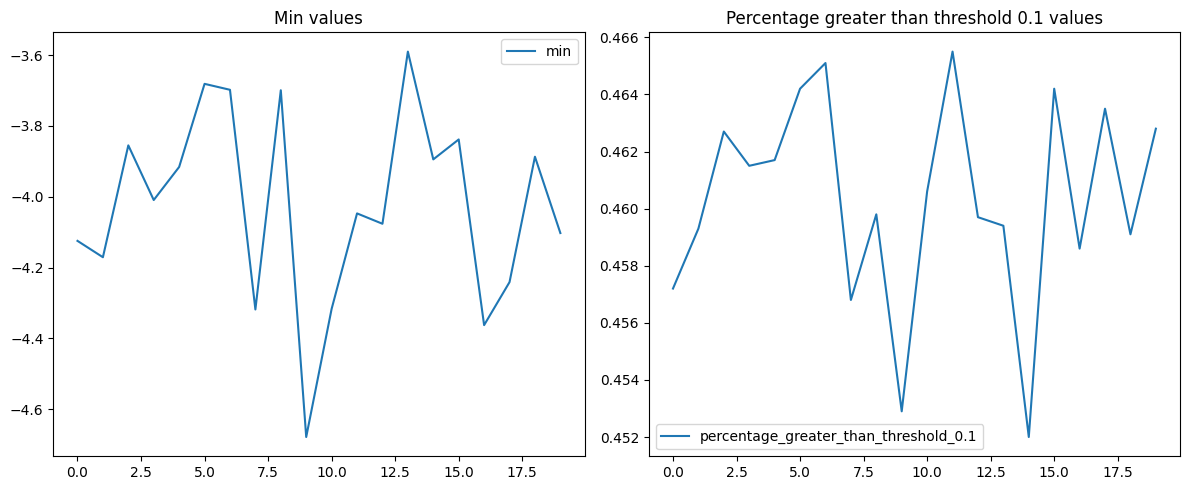

In [ ]:
from custom_feature_dir.utils import plot_stats

plot_stats(log_dir)


To summarize, we have shown how to implement a custom feature for logging a custom statistic. Note, however, that in the example we have shown, we do not implement the logic for multi-node training. Such logic is implemented for all stats provided by the `LogTensorStats` and `LogFp8TensorStats` features.